# FESDModel

FESD - Fault estimation for skeleton detection - is a suite that aims at finding faults in joints of skeletons, which are detected by human pose estimatiors.

FESDData is the sister project to this notebook, which aims at recording depth and rgb data, as well as populating the data with human poses from variing human pose estimators.

Furthermore, FESTData augments all data based on joint confidence.

FFESDModel aims to develop and evaluate a model based on the faulty and augmented joint data as well as RGBD data.

## Libraries

We need a range of libraries which are imported here. We also define some constants.

In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [ ]:
import os
from pathlib import Path
from time import time

from data import FESDDataset, err2gt, gt2err
from data import Frame, AugmentationParams
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

import cv2

from model import FESD, train, val, test
import copy

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# import tensorflow as tf
import datetime

from utils import AvgMeter, clip_gradient, get_scheduler

from tqdm import tqdm

num_gpus = torch.cuda.device_count()
print(f"Num cuda GPUs: {num_gpus}")
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [ ]:
RECORDING_DIR = Path('H:/Recordings/')
CHECKPOINT_DIR = Path('checkpoints')

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

In [ ]:
# Reduce number of frames

# for file in os.listdir(RECORDING_DIR):
#   if (file.endswith('.json')):
#     with open(file=os.path.join(RECORDING_DIR, file), mode="r") as jsonFile:
#       data = json.load(jsonFile)
      
#     data["Frames"] = 30

#     with open(file=os.path.join(RECORDING_DIR, file), mode="w") as jsonFile:
#       json.dump(data, jsonFile)

In [ ]:
# Reduce number of joints (remove unused joints)

# for file in os.listdir(RECORDING_DIR):
#   if (file.endswith('.json')):
#     with open(file=os.path.join(RECORDING_DIR, file), mode="r") as jsonFile:
#       data = json.load(jsonFile)

#     with open(file=RECORDING_DIR /  data['Skeleton'], mode='r') as skelFile:
#       skeleton_json = json.load(skelFile)
  
#     for frame in skeleton_json:
#       # remove index 0, 10, 16, 20, 24
#       for skeleton in frame:
#         skeleton['Skeleton'] = [skeleton['Skeleton'][i] for i in range(len(skeleton['Skeleton'])) if i not in [0, 10, 16, 20, 24]]
    
#     with open(file=RECORDING_DIR /  data['Skeleton'], mode="w") as skelFile:
#       json.dump(skeleton_json, skelFile)
    

## Data Loading

Firstly we need to import all the recordings into the notebook.


In [ ]:
with open(file="Exercises.json", mode='r') as file:
  exercises_json = json.load(file)['Exercises']

with open(file="JointErrors.json", mode='r') as file:
  joint_error_json = json.load(file)

with open(file="SkeletonErrors.json", mode='r') as file:
  skeleton_error_json = json.load(file)

len(exercises_json)

In [ ]:
batchsize = 10
train_size = 300
joint_names_all = ["-", "Head", "Neck", "Torso", "Waist", "Left collar", "Left shoulder", "Left elbow", "Left wrist", "Left hand", "-", "Right collar", "Right shoulder", "Right elbow", "Right wrist", "Right hand", "-", "Left hip", "Left knee", "Left ankle", "-", "Right hip", "Right knee", "Right ankle", "-"]
joint_names = [i for i in joint_names_all if i != '-']

dataset_train = FESDDataset(RECORDING_DIR, train_size)

dataset_test = FESDDataset(RECORDING_DIR, train_size, test=True)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize)
test_loader = torch.utils.data.DataLoader(dataset_test)

print(len(train_loader))
print(len(test_loader))

In [ ]:
rgb, depth, pose_2d, gt, session = dataset_train[0]
dataset_train.frame.show()

print(rgb.shape, depth.shape, pose_2d.shape, gt.shape)
gt2err(gt)

In [ ]:
cols = ['Type', 'Session', 'Difficulty', 'Exercise', 'Frame', 'Joint', 'Error']
df = pd.DataFrame(columns=cols)

for i in tqdm(range(len(dataset_train))):
  _, _, _, gt, _ = dataset_train[i]
  gt = gt2err(gt)[0]
  session, frame_i = dataset_train.get_index(i)
  frame = dataset_train.frame
  session_name = frame.session["Name"]
  exercise = frame.session['Session Parameters']['Exercise']
  difficulty = int(exercise[2])

  if (len(gt) != len(joint_names)):
    print(f"Error: {len(gt)} != {len(joint_names)}")
    continue

  for j in range(0, len(gt)):
    row = ["Train", session_name, difficulty, exercise, frame_i, j, gt.tolist()[j]]
    df.loc[len(gt) * i + j] = row

offset = len(df)

for i in tqdm(range(len(dataset_test))):
  _, _, _, gt, _ = dataset_test[i]
  gt = gt2err(gt)[0]
  session, frame_i = dataset_test.get_index(i)
  frame = dataset_test.frame
  session_name = frame.session["Name"]
  exercise = frame.session['Session Parameters']['Exercise']
  difficulty = int(exercise[2])
  
  if (len(gt) != len(joint_names)):
    print(f"Error: {len(gt)} != {len(joint_names)}, {session_name}, {frame_i}")
    continue

  for j in range(0, len(gt)):
    row = ["Test", session_name, difficulty, exercise, frame_i, j, gt.tolist()[j]]
    df.loc[offset + len(gt) * i + j] = row
  
df

In [ ]:
df["Joint Name"] = df["Joint"].apply(lambda x: joint_names[x])
df["Simple Error"] = df["Error"] != 0
df["Difficulty Name"] = df["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
df

In [ ]:
joint_errors = []
for je in joint_error_json:
  joint_errors.append(je["Name"])

In [ ]:
ax = df[["Error", "Frame"]].groupby("Error").count().plot.pie(subplots=True, figsize=(4, 4), title="Error Distribution", labels=joint_errors, autopct='%1.1f%%', pctdistance=1.25, fontsize=12, explode=(.1,.1,.1,.1), labeldistance=None)

ax[0].set_ylabel("")
ax[0].legend(bbox_to_anchor=(1, 1.02), loc='center left')

plt.savefig("figures/Error_Distribution.png")
plt.plot()

In [ ]:
error_by_difficulty = df[['Difficulty', "Difficulty Name", "Simple Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Simple Error"]
ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.get_figure().savefig("figures/Error_Rate_by_Difficulty.png")
ax

In [ ]:
err_group = df[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name", "Error"]).count()["Difficulty"].unstack().T
error_distribution_by_difficulty = (err_group / err_group.sum()).T
error_distribution_by_difficulty['sort_key'] = pd.CategoricalIndex(error_distribution_by_difficulty, [3, 0, 2, 1])
error_distribution_by_difficulty.sort_values('sort_key', inplace=True)
error_distribution_by_difficulty.drop('sort_key', axis=1, inplace=True)

axs = error_distribution_by_difficulty.T.plot.pie(subplots=True, figsize=(10, 10), layout=(2, 2), legend=False, title="Error Distribution by Difficulty", labels=joint_errors, autopct='%1.1f%%', pctdistance=1.25, fontsize=12, explode=(.1,.1,.1,.1), sharex=False, sharey=False, labeldistance=None)

axs[0, 0].set_xlabel("Trivial")
axs[0, 0].set_ylabel("")
axs[0, 1].set_xlabel("Easy")
axs[0, 1].set_ylabel("")
axs[0, 1].legend(bbox_to_anchor=(1, 1.02), loc='center left')
axs[1, 0].set_xlabel("Medium")
axs[1, 0].set_ylabel("")
axs[1, 1].set_xlabel("Hard")
axs[1, 1].set_ylabel("")

plt.tight_layout()
plt.savefig("figures/Error_Distribution_by_Difficulty.png")
plt.plot()

In [ ]:
s = df[["Joint", "Simple Error"]].groupby(["Joint"]).sum()
s["Sorted Names"] = joint_names
s = s.sort_values(by="Simple Error", ascending=False)

err_joints = df[["Joint", "Joint Name", "Error"]]
error_distribution_by_joint = err_joints.groupby(["Joint", "Error"]).count().unstack().reindex(s.index).T

error_distribution_by_joint = (error_distribution_by_joint / error_distribution_by_joint.sum()).T.fillna(0)
error_distribution_by_joint.columns = error_distribution_by_joint.columns.droplevel()

error_distribution_by_joint.index = s["Sorted Names"].tolist()

edj = error_distribution_by_joint.T

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)

axs = edj.plot.pie(ax=ax1, subplots=True, figsize=(10, 10), layout=(4, 5), legend=False, title="Error Distribution by Joint", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.05,.05,.1))

for ax in axs.flatten():
  ax.set_xlabel(ax.get_ylabel())
  ax.set_ylabel("")

plt.legend(joint_errors, loc='upper left', bbox_to_anchor=(1, 1))

ax1.set_title("Error Distribution by Joint")
plt.savefig("figures/Error_Distribution_by_Joint.png")
plt.plot()

### Build Model


In [ ]:
model = FESD()
print(model)

is_cuda = True

model = nn.DataParallel(model)

if is_cuda:
  model = model.cuda()

## Train Model

In the following we define the training function and train a network on the training data.

In [ ]:
# epoch number
epochs = 150
# optimizer
optim = 'adam'
# learning rate
learning_rate = 0.000025
# learning rate scheduler. can be step, poly or cosine
lr_scheduler = 'cosine'
# warmup epoch
warmup_epoch = -1
# warmup multiplier
warmup_multiplier = 100
# for step scheduler. where to decay lr, can be a list
lr_decay_epochs = [120, 160, 200]
# for step scheduler. step size to decay lr
lr_decay_steps = 20 
# for step scheduler. decay rate for learning rate
lr_decay_rate = 0.01
# weight decay
weight_decay = 0.0001
# momentum for SGD
momentum = 0.9
# gradient clipping margin
clip = 0.5

In [ ]:
n_data = len(train_loader.dataset)
CE = torch.nn.CrossEntropyLoss()
if is_cuda:
    CE = CE.cuda()

if optim == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
elif optim == 'adamW':
    optimizer = torch.optim.AdamW(model.parameters(), learning_rate, weight_decay=weight_decay)
elif optim == 'sdg':
    optimizer = torch.optim.SGD(model.parameters(), learning_rate / 10.0 * batchsize, momentum=momentum, weight_decay=weight_decay)

scheduler = get_scheduler(optimizer, len(train_loader), lr_scheduler, lr_decay_epochs, lr_decay_steps, lr_decay_rate, epochs, warmup_epoch, warmup_multiplier)

In [ ]:
len(model_columns)

In [ ]:
model_columns = ["epoch", "iteration", "joint_id",
                  "gts", "preds", "confidences", 
                  "Avg loss", "loss", "accuracy", 
                  "tp", "tn", "fp", "fn", "precision", "recall", "f1", 
                  "cohens_kappa", "learning_rate",
                  "train_test", "exercise", "simplified"]
df_model = pd.DataFrame(columns=model_columns)

# routine
for epoch in tqdm(range(1, epochs + 1)):
    
    tic = time()

    torch.cuda.empty_cache()
    train(train_loader, model, optimizer, CE, scheduler, clip, epoch, epochs, writer, is_cuda, df_model)

    torch.cuda.empty_cache()
    # val(validation_loader, model, CE, epoch, epochs, writer)
    tqdm.write(f'epoch {epoch}, total time {time() - tic:.2f}, learning_rate {optimizer.param_groups[0]["lr"]}')

    if (epoch) % 10 == 0:
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"{epoch}_ckpt.pth"))

        tqdm.write("checkpoint saved {}!".format(os.path.join(CHECKPOINT_DIR, f"{epoch}_ckpt.pth")))
        
torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"last_ckpt.pth"))
print(f"model saved {os.path.join(CHECKPOINT_DIR, f'last_ckpt.pth')}!")
checkpoint = os.path.join(CHECKPOINT_DIR, f"last_ckpt.pth")
df_model.to_csv("ModelAnalysis.csv")

In [ ]:
input_names = ["RGB", "Depth", "Joints"]
output_names = ["Errors"]

torch.onnx.export(model, (rgb, depth, pose_2d), 'FESD.onnx', input_names=input_names, output_names=output_names)

In [133]:
test(test_loader, model, CE, writer, is_cuda, df_model)

In [ ]:
df_model.to_csv("ModelAnalysis.csv")

## Training Evaluation

Here we create all graphs and analysis for the training

In [ ]:
df_model = pd.read_csv("ModelAnalysis.csv").drop('Unnamed: 0', axis=1)
df_model.head()

In [132]:
df_model.groupby("epoch").mean()["accuracy"]

C:\Users\pohly\AppData\Local\Temp\ipykernel_3992\1933001456.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_model.groupby("epoch").mean()["accuracy"]


epoch
1      0.365931
2      0.360833
3      0.360147
4      0.363235
5      0.360637
         ...   
98     0.338971
99     0.347500
100    0.342402
101    0.342010
102    0.308750
Name: accuracy, Length: 102, dtype: float64

In [ ]:
df_train = df_model[df_model['train_test'] == 'train']
df_test = df_model[df_model['train_test'] == 'test']
df_train.head()

<Axes: xlabel='epoch'>

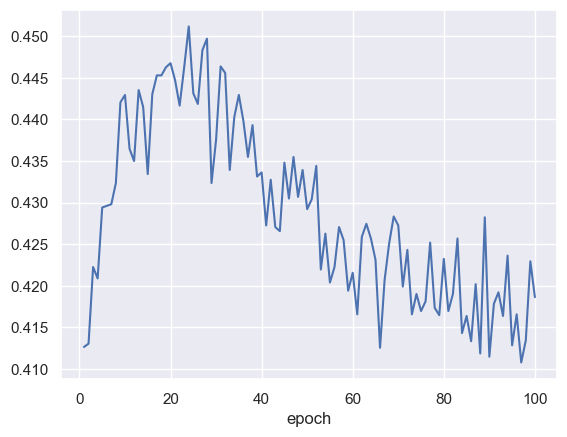

In [ ]:
df_train[df_train["simplified"] == True].groupby("epoch").mean(numeric_only=True)["accuracy"].plot()

In [ ]:
df_test[df_test['simplified'] == False].mean()

C:\Users\leona\AppData\Local\Temp\ipykernel_15996\2497244461.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_test[df_test['simplified'] == False].mean()


epoch            0.000000e+00
iteration        1.355000e+02
Avg loss        -1.411939e+11
loss            -1.403079e+11
accuracy         3.211111e-01
tp               6.422222e+00
tn               6.422222e+00
fp               1.357778e+01
fn               1.357778e+01
precision        3.211111e-01
recall           3.211111e-01
f1               1.605556e-01
cohens_kappa              NaN
learning_rate             NaN
simplified       0.000000e+00
dtype: float64

In [ ]:
loss = 0
for j in range(0, 20):
  print(gt, pred)
  loss += CE(gt[:,j], pred[:,j])
loss

tensor(635.1016, dtype=torch.float64)

In [ ]:
#np.array(gts[0])
gts[0]
gt = torch.tensor(np.array(json.loads(gts[5])))
pred = torch.tensor(np.array(json.loads(preds[5])))


In [ ]:
len(gts) * 20

102000

In [ ]:
df_train_test_cp = df_train_test.copy()

In [ ]:
gts = np.array(df_train[df_train['simplified'] == False]["gts"].tolist())
preds = np.array(df_train[df_train['simplified'] == False]["preds"].tolist())
exercises = np.array(df_train[df_train['simplified'] == False]["exercise"].tolist())

model_columns_test = ["epoch", "iteration", "joint_id",
                  "gts", "preds", "confidences", 
                  "Avg loss", "loss", "accuracy", 
                  "tp", "tn", "fp", "fn", "precision", "recall", "f1", 
                  "cohens_kappa", "learning_rate",
                  "train_test", "exercise", "simplified"]

df_train_test = pd.DataFrame(columns=model_columns_test)

for it, (gt, pred, exercise) in tqdm(enumerate(zip(gts, preds, exercises)), total=len(gts)):
  i = it % len(train_loader)
  epoch = it // len(train_loader)

  gt = torch.tensor(np.array(json.loads(gt)))
  pred = torch.tensor(np.array(json.loads(pred)))
  
  loss = 0

  for j in range(0, 20):
    loss += CE(gt[:,j], pred[:,j])

  loss_record = AvgMeter()

  loss_record.update(loss.data, 1)

  val(pred, gt, loss_record, loss, np.NaN, epoch, epochs, i, len(train_loader), "train",  exercise, df_train_test)  

 91%|█████████▏| 4666/5100 [2:20:09<18:55,  2.62s/it]     

In [ ]:
gts = np.array(df_test[df_test['simplified'] == False]["gts"].tolist())
preds = np.array(df_test[df_test['simplified'] == False]["preds"].tolist())
exercises = np.array(df_test[df_test['simplified'] == False]["exercise"].tolist())

model_columns_test = ["epoch", "iteration", "joint_id",
                  "gts", "preds", "confidences", 
                  "Avg loss", "loss", "accuracy", 
                  "tp", "tn", "fp", "fn", "precision", "recall", "f1", 
                  "cohens_kappa", "learning_rate",
                  "train_test", "exercise", "simplified"]

df_test_test = pd.DataFrame(columns=model_columns_test)

for it, (gt, pred, exercise) in tqdm(enumerate(zip(gts, preds, exercises)), total=len(gts)):
  i = it % len(train_loader)
  epoch = it // len(train_loader)

  gt = torch.tensor(np.array(json.loads(gt)))
  pred = torch.tensor(np.array(json.loads(pred)))
  
  loss = 0

  for j in range(0, 20):
    loss += CE(gt[:,j], pred[:,j])

  loss_record = AvgMeter()

  loss_record.update(loss.data, 1)

  val(pred, gt, loss_record, loss, np.NaN, epoch, epochs, i, len(train_loader), "test",  exercise, df_test_test)  

100%|██████████| 270/270 [01:41<00:00,  2.65it/s]


In [ ]:
gt[:,0]

tensor([0.], dtype=torch.float64)

In [ ]:
df_test_test["joint_name"] = df_test_test.apply(lambda x: joint_names[x["joint_id"]], axis=1)

In [ ]:
df_test_test[df_test_test["exercise"] == "E-1.01"][df_test_test["simplified"] == True].reset_index()

C:\Users\leona\AppData\Local\Temp\ipykernel_15996\71018840.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_test[df_test_test["exercise"] == "E-1.01"][df_test_test["simplified"] == True].reset_index()


,index,epoch,iteration,joint_id,gts,preds,confidences,Avg loss,loss,accuracy,...,fn,precision,recall,f1,cohens_kappa,learning_rate,train_test,exercise,simplified,joint_name
0,3601,1,39,0,[0.0],[1.0],NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,0.0,NaN,test,E-1.01,True,Head
1,3603,1,39,1,[0.0],[0.0],NaN,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaN,NaN,test,E-1.01,True,Neck
2,3605,1,39,2,[0.0],[1.0],NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,0.0,NaN,test,E-1.01,True,Torso
3,3607,1,39,3,[0.0],[0.0],NaN,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaN,NaN,test,E-1.01,True,Waist
4,3609,1,39,4,[0.0],[0.0],NaN,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaN,NaN,test,E-1.01,True,Left collar
5,3611,1,39,5,[0.0],[1.0],NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,0.0,NaN,test,E-1.01,True,Left shoulder
6,3613,1,39,6,[0.0],[1.0],NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,0.0,NaN,test,E-1.01,True,Left elbow
7,3615,1,39,7,[0.0],[1.0],NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,0.0,NaN,test,E-1.01,True,Left wrist
8,3617,1,39,8,[1.0],[1.0],NaN,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaN,NaN,test,E-1.01,True,Left hand
9,3619,1,39,9,[0.0],[1.0],NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,0.0,NaN,test,E-1.01,True,Right collar


In [ ]:
38*20

760

In [ ]:
tps = df_test_test[df_test_test["simplified"] == True].groupby(["exercise"]).sum(numeric_only=True)[["tp", "tn", "fp", "fn", "accuracy"]]
tps["positives"] = tps["tp"] + tps["fn"]
tps["negatives"] = tps["tn"] + tps["fp"]
tps["accuracy"] = tps["accuracy"] / (tps["positives"] + tps["negatives"])
tps.sort_values('accuracy', ascending= False).sort_index(level='exercise', sort_remaining=False)
pd.set_option('display.max_rows', None)
tps = tps.sort_values('accuracy', ascending= False).sort_index(level='exercise', sort_remaining=False)
tps

,tp,tn,fp,fn,accuracy,positives,negatives
exercise,,,,,,,
E-0.01,583.0,67.0,35.0,1115.0,0.361111,1698.0,102.0
E-1.01,403.0,46.0,13.0,738.0,0.374167,1141.0,59.0
E-2.01,336.0,151.0,64.0,649.0,0.405833,985.0,215.0
E-3.01,183.0,440.0,237.0,340.0,0.519167,523.0,677.0


NameError: name 'tps' is not defined

In [ ]:
df_train_test[df_train_test["simplified"] == True][df_train_test["train_test"] == 'train'].groupby(["joint_id"]).mean()

C:\Users\leona\AppData\Local\Temp\ipykernel_15996\2761635824.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_test[df_train_test["simplified"] == True][df_train_test["train_test"] == 'train'].groupby(["joint_id"]).mean()
C:\Users\leona\AppData\Local\Temp\ipykernel_15996\2761635824.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_train_test[df_train_test["simplified"] == True][df_train_test["train_test"] == 'train'].groupby(["joint_id"]).mean()


,epoch,iteration,confidences,Avg loss,loss,accuracy,tp,tn,fp,fn,precision,recall,f1,cohens_kappa,learning_rate,simplified
joint_id,,,,,,,,,,,,,,,,
0,14.807816,24.801409,NaN,604.237155,604.237155,0.612428,5.836003,0.288277,0.520820,3.354901,0.612428,0.612428,0.612428,-0.006229,NaN,1.0
1,14.807816,24.801409,NaN,604.237155,604.237155,0.442921,4.068546,0.360666,0.312620,5.258168,0.442921,0.442921,0.444916,-0.002501,NaN,1.0
2,14.807816,24.801409,NaN,604.237155,604.237155,0.192633,1.358104,0.568225,0.085842,7.987828,0.192633,0.192633,0.236028,0.002650,NaN,1.0
3,14.807816,24.801409,NaN,604.237155,604.237155,0.829084,8.237028,0.053812,1.330557,0.378603,0.829084,0.829084,0.829615,0.000140,NaN,1.0
4,14.807816,24.801409,NaN,604.237155,604.237155,0.795131,7.839206,0.112108,0.541960,1.506726,0.795131,0.795131,0.795131,0.002769,NaN,1.0
5,14.807816,24.801409,NaN,604.237155,604.237155,0.209865,1.659193,0.439462,0.099295,7.802050,0.209865,0.209865,0.245026,-0.001829,NaN,1.0
6,14.807816,24.801409,NaN,604.237155,604.237155,0.246252,1.360666,1.101858,0.178732,7.358744,0.246252,0.246252,0.302201,0.004619,NaN,1.0
7,14.807816,24.801409,NaN,604.237155,604.237155,0.353748,1.800769,1.736707,0.536195,5.926329,0.353748,0.353748,0.370107,-0.002968,NaN,1.0
8,14.807816,24.801409,NaN,604.237155,604.237155,0.303203,0.249840,2.782191,0.117233,6.850737,0.303203,0.303203,0.406965,-0.000737,NaN,1.0
